In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydataset import data
import statistics
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
# importing my personal wrangle module
import wrangle
import model
import viz

In [2]:
# Acquiring the data using the wrangle
zillow_sql_query = wrangle.get_zillow_data()
# I am working with a copy of the SQL query to be able to access it faster
zillow = zillow_sql_query.copy()

In [3]:
zillow = wrangle.clean_and_prep_data(zillow)

In [4]:
encoded = wrangle.encode_zillow(zillow)

In [5]:
train, validate, test,X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.split_zillow(encoded)

In [6]:
train_scaled, X_train_scaled, y_train_scaled, \
validate_scaled, X_validate_scaled, y_validate_scaled, \
test_scaled, X_test_scaled, y_test_scaled = wrangle.scale_zillow(train, validate, test)

In [7]:
X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe \
= model.create_data_for_models(X_train_scaled, X_validate_scaled, X_test_scaled)

In [8]:
train.bathrooms.value_counts()

2.0    11783
3.0     5084
1.0     4956
2.5     2061
4.0      529
1.5      464
3.5      246
Name: bathrooms, dtype: int64

In [9]:
copy = train.copy()
copy

,bedrooms,bathrooms,sq_ft,tax_value,county,age,sq_ft_per_bathroom,LA,Orange,Ventura
44364,3.0,2.0,2525.0,347114.0,LA,84,1262.500000,1,0,0
46624,4.0,2.0,1337.0,500000.0,Orange,67,668.500000,0,1,0
11864,3.0,4.0,2881.0,757360.0,LA,69,720.250000,1,0,0
15449,2.0,1.0,1397.0,520117.0,Orange,74,1397.000000,0,1,0
25692,2.0,1.0,1103.0,137886.0,LA,116,1103.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...
17012,2.0,2.0,1424.0,529764.0,LA,67,712.000000,1,0,0
51716,4.0,3.0,2133.0,95220.0,LA,67,711.000000,1,0,0
27316,3.0,2.0,2442.0,159427.0,LA,69,1221.000000,1,0,0
46126,3.0,2.0,1080.0,147044.0,LA,30,540.000000,1,0,0


In [10]:
copy.bathrooms.value_counts()

2.0    11783
3.0     5084
1.0     4956
2.5     2061
4.0      529
1.5      464
3.5      246
Name: bathrooms, dtype: int64

In [11]:
# copy['has_half_bath'] = copy[copy.bathrooms == '1.5']

In [12]:
# 1. Predict tax_value_pred_mean
# I create here new columns in the y_ data sets too hold the baseline value I am working with.
tax_value_pred_mean = y_train_scaled.tax_value.mean()
y_train_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean, 2)
y_validate_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)
y_test_scaled['tax_value_pred_mean'] = round(tax_value_pred_mean,2)

In [13]:
# 2. RMSE of tax_value_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train_scaled.tax_value,
                                y_train_scaled.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.tax_value, y_validate_scaled.tax_value_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.21 
Validate/Out-of-Sample:  0.21


In [14]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898


In [15]:
metric_df = model.run_all_models_on_all_data(X_train_kbest, y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, X_validate_rfe, X_test_kbest, X_test_rfe, metric_df)

In [16]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.208883,0.208898
1,OLS Regressor RFE,0.186380,0.185511
2,OLS Regressor KBEST,0.187970,0.187550
3,Lasso_alpha1_KBEST,0.208851,0.208888
4,Lasso_alpha1_RFE,0.208851,0.208888
5,glm_compound_kbest,0.187992,0.187311
6,glm_compound_rfe,0.186132,0.185047
7,quadratic_kbest,0.187065,0.186616
8,quadratic_rfe,0.185730,0.184879


In [17]:
# Make the polynomial features to get a new set of features. import from sklearn
pf = PolynomialFeatures(degree=2)

# Fit and transform X_train_scaled
X_train_degree2_rfe = pf.fit_transform(X_train_rfe)

# Transform X_validate_scaled & X_test_scaled
X_validate_degree2_rfe = pf.transform(X_validate_rfe)
X_test_degree2_rfe =  pf.transform(X_test_rfe)

In [18]:
# I use the RFE features here:
# Create the model object
lm2 = LinearRegression()

# Fit the model to our test data. 
lm2.fit(X_test_degree2_rfe, y_test_scaled.tax_value)

# Create a column in the y_test_scaled dataframe to hold the polynomial regression prediction:
y_test_scaled['tax_value_pred_lm2_rfe'] = lm2.predict(X_test_degree2_rfe)

# Evaluate by calculating its RMSE on test
rmse_test = mean_squared_error(y_test_scaled.tax_value, y_test_scaled.tax_value_pred_lm2_rfe) ** (1/2)
# A statement reminding us of the RMSE on the train and validate samples:
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", metric_df.RMSE_train.iloc[8], 
      "\nValidation/Out-of-Sample: ", metric_df.RMSE_validate.iloc[8],)



RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.18573040401903843 
Validation/Out-of-Sample:  0.18487887876821385


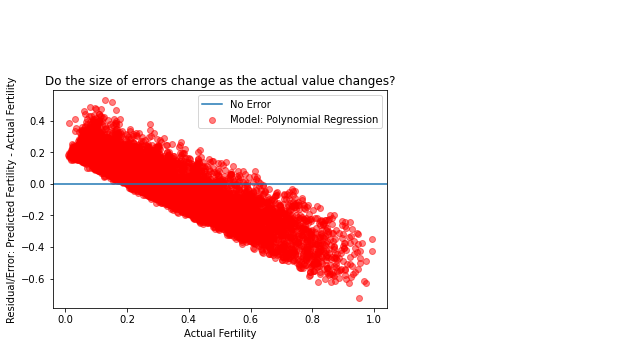

In [23]:
# plt.figure(figsize=(5,5))
plt.axhline(label="No Error")
plt.scatter(y_test_scaled.tax_value, y_test_scaled.tax_value_pred_lm2_rfe - y_test_scaled.tax_value,\
            alpha=.5, color="red", label="Model: Polynomial Regression")
# plt.scatter(y_validate.Fertility, y_validate.Fert_pred_glm - y_validate.Fertility, 
#             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
# plt.scatter(y_validate.Fertility, y_validate.Fert_pred_lm2 - y_validate.Fertility, 
#             alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Fertility")
plt.ylabel("Residual/Error: Predicted Fertility - Actual Fertility")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (1,1))
plt.annotate("The TweedieRegressor\n appears to be most consistent, along with OLS", (1,1))
plt.show()